In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
%pip install shap
import shap

Note: you may need to restart the kernel to use updated packages.


In [6]:
behavior_df = pd.read_csv('behavioural_dataset.csv')
cars_df = pd.read_csv('CAR DETAILS FROM CAR DEKHO.csv')
lifestyle_df = pd.read_csv('lifestyle.csv')


In [7]:
behavior_df.head()

,Age,Profession,Marrital Status,Education,No of Dependents,Personal loan,Total Salary,Price
0,27,Salaried,Single,Post Graduate,0,Yes,800000,800000
1,35,Salaried,Married,Post Graduate,2,Yes,2000000,1000000
2,45,Business,Married,Graduate,4,Yes,1800000,1200000
3,41,Business,Married,Post Graduate,3,No,2200000,1200000
4,31,Salaried,Married,Post Graduate,2,Yes,2600000,1600000


In [8]:
cars_df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [9]:
lifestyle_df.head()

,Income,Age,Dependents,Occupation,City_Tier,Rent,Loan_Repayment,Insurance,Groceries,Transport,...,Desired_Savings,Disposable_Income,Potential_Savings_Groceries,Potential_Savings_Transport,Potential_Savings_Eating_Out,Potential_Savings_Entertainment,Potential_Savings_Utilities,Potential_Savings_Healthcare,Potential_Savings_Education,Potential_Savings_Miscellaneous
0,44637.249636,49,0,Self_Employed,Tier_1,13391.174891,0.000000,2206.490129,6658.768341,2636.970696,...,6200.537192,11265.627707,1685.696222,328.895281,465.769172,195.151320,678.292859,67.682471,0.000000,85.735517
1,26858.596592,34,2,Retired,Tier_2,5371.719318,0.000000,869.522617,2818.444460,1543.018778,...,1923.176434,9676.818733,540.306561,119.347139,141.866089,234.131168,286.668408,6.603212,56.306874,97.388606
2,50367.605084,35,1,Student,Tier_3,7555.140763,4612.103386,2201.800050,6313.222081,3221.396403,...,7050.360422,13891.450624,1466.073984,473.549752,410.857129,459.965256,488.383423,7.290892,106.653597,138.542422
3,101455.600247,21,0,Self_Employed,Tier_3,15218.340037,6809.441427,4889.418087,14690.149363,7106.130005,...,16694.965136,31617.953615,1875.932770,762.020789,1241.017448,320.190594,1389.815033,193.502754,0.000000,296.041183
4,24875.283548,52,4,Professional,Tier_2,4975.056710,3112.609398,635.907170,3034.329665,1276.155163,...,1874.099434,6265.700532,788.953124,68.160766,61.712505,187.173750,194.117130,47.294591,67.388120,96.557076


In [10]:
behavior_df = pd.read_csv("behavioural_dataset.csv")
car_df = pd.read_csv("CAR DETAILS FROM CAR DEKHO.csv")
lifestyle_df = pd.read_csv("lifestyle.csv")

In [11]:
cars_df = pd.read_csv('CAR DETAILS FROM CAR DEKHO.csv')
cars_df['fuel'] = cars_df['fuel'].str.lower()
cars_df['is_ev'] = cars_df['fuel'].apply(lambda x: 1 if 'electric' in x else 0)
cars_df['year'] = pd.to_numeric(cars_df['year'], errors='coerce')
cars_df.dropna(subset=['year'], inplace=True)

In [12]:
lifestyle_df['High_Income'] = lifestyle_df['Disposable_Income'].apply(lambda x: 1 if x > 30000 else 0)

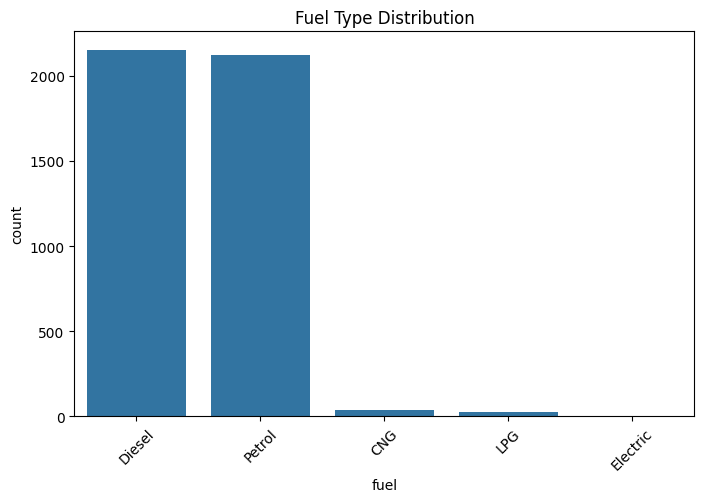

In [13]:
plt.figure(figsize=(8,5))
sns.countplot(data=car_df, x='fuel', order=car_df['fuel'].value_counts().index)
plt.title("Fuel Type Distribution")
plt.xticks(rotation=45)
plt.show()

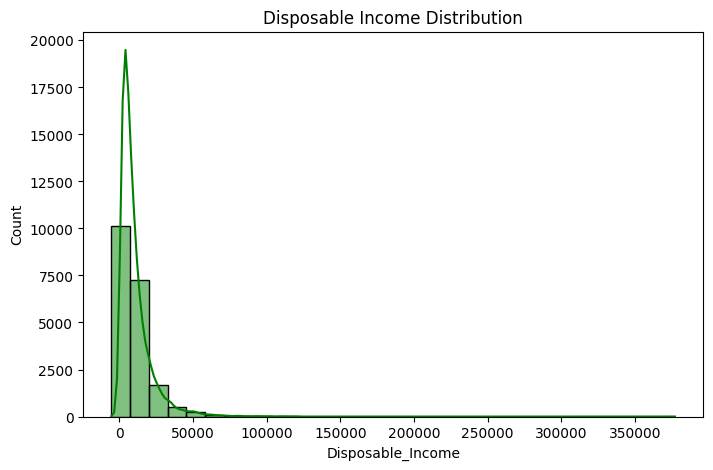

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(lifestyle_df['Disposable_Income'], kde=True, bins=30, color="green")
plt.title("Disposable Income Distribution")
plt.show()

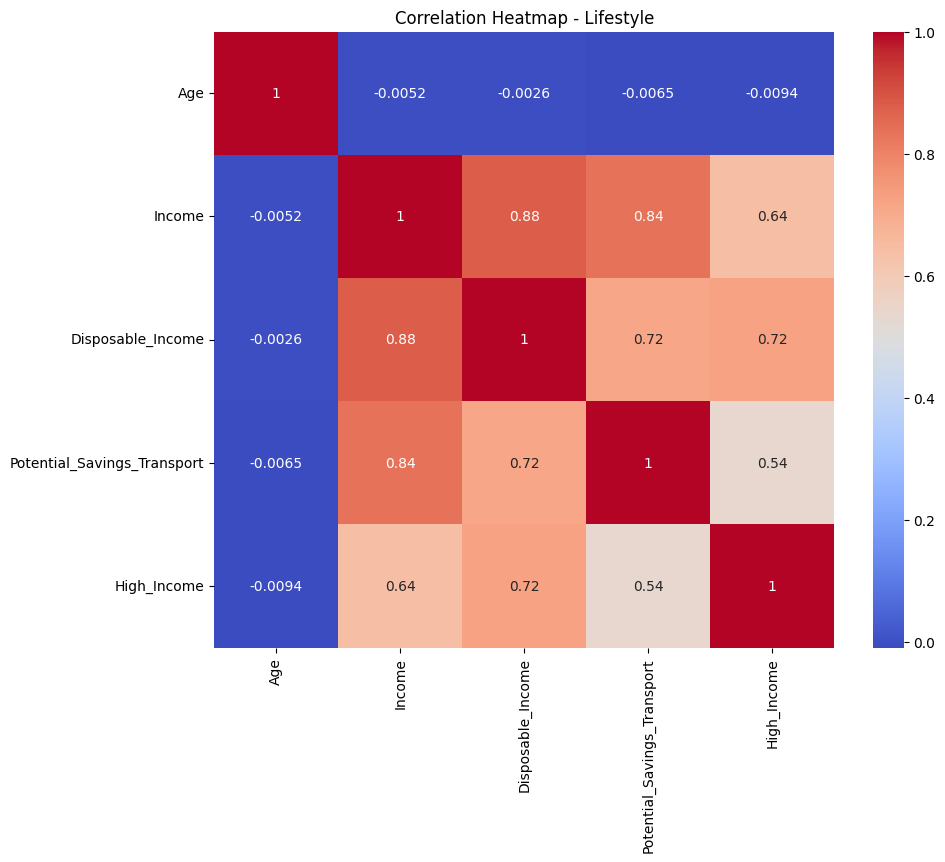

In [15]:
plt.figure(figsize=(10,8))
sns.heatmap(lifestyle_df[['Age', 'Income', 'Disposable_Income', 'Potential_Savings_Transport', 'High_Income']].corr(), 
            annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap - Lifestyle")
plt.show()

In [19]:
merged = pd.concat([
    lifestyle_df[['Age', 'Income', 'Disposable_Income', 'City_Tier', 'Transport', 'Potential_Savings_Transport']].reset_index(drop=True),
    behavior_df[['Education', 'Profession', 'Personal loan', 'Total Salary']].reset_index(drop=True)
], axis=1)

In [20]:
merged['Interested_in_EV'] = ((merged['Disposable_Income'] > 30000) & 
                              (merged['Potential_Savings_Transport'] > 500)).astype(int)

In [23]:
merged['Education'] = merged['Education'].astype('category').cat.codes
merged['Profession'] = merged['Profession'].astype('category').cat.codes
merged['Transport'] = merged['Transport'].astype('category').cat.codes
merged['City_Tier'] = merged['City_Tier'].astype('category').cat.codes
merged['Personal loan'] = merged['Personal loan'].map({'Yes': 1, 'No': 0})

print("Remaining object columns:", merged.select_dtypes(include='object').columns.tolist())

Remaining object columns: []


In [ ]:
X = merged.drop('Interested_in_EV', axis=1)
y = merged['Interested_in_EV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

Confusion Matrix:
 [[3811    0]
 [   0  189]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3811
           1       1.00      1.00      1.00       189

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



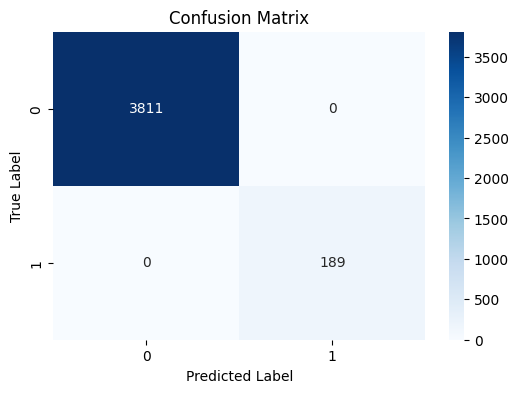

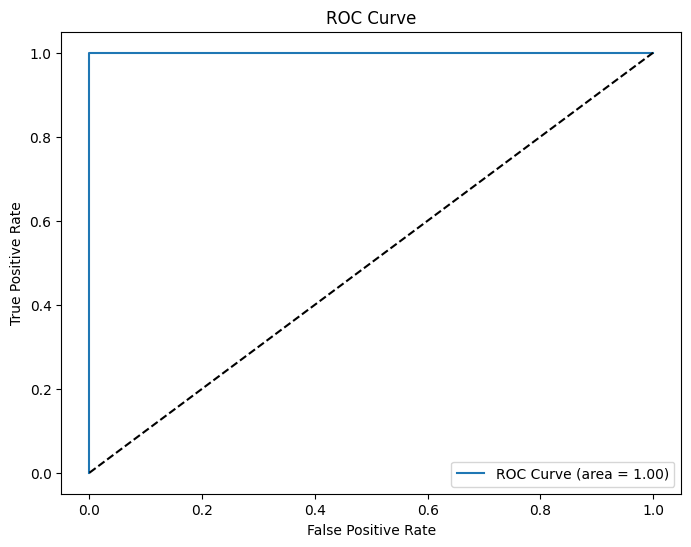

In [ ]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

y_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

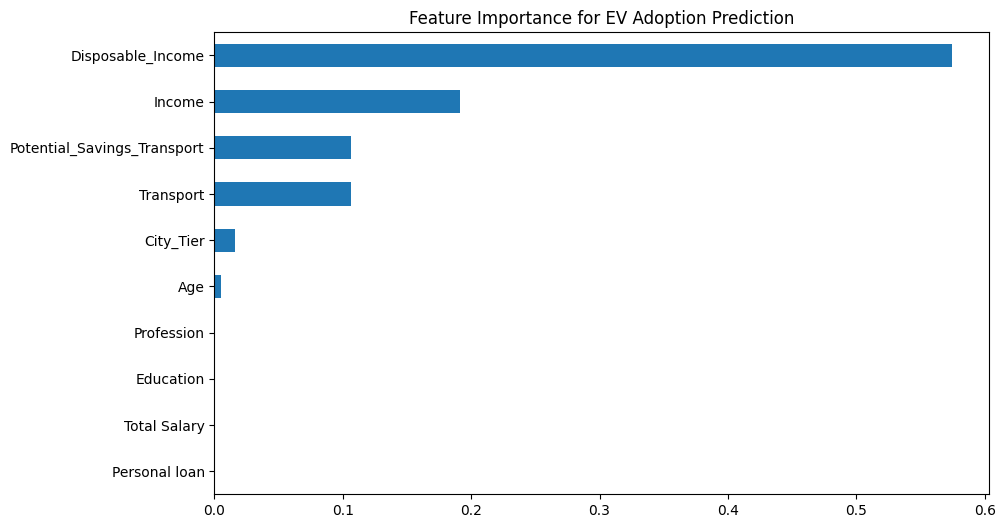

In [26]:
plt.figure(figsize=(10,6))
feature_imp = pd.Series(rf.feature_importances_, index=X.columns)
feature_imp.sort_values(ascending=True).plot(kind='barh')
plt.title("Feature Importance for EV Adoption Prediction")
plt.show()

In [27]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best CV Score: 0.999875


In [28]:
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
print("Tuned Model - Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nTuned Model - Classification Report:\n", classification_report(y_test, y_pred_best))


Tuned Model - Confusion Matrix:
 [[3811    0]
 [   0  189]]

Tuned Model - Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3811
           1       1.00      1.00      1.00       189

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [ ]:
clustering_features = merged[['Age', 'Income', 'Disposable_Income', 'Total_Salary']]

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  
clustering_features_imputed = imputer.fit_transform(clustering_features)


In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

clustering_features = merged[['Age', 'Income', 'Disposable_Income', 'Total Salary']]
imputer = SimpleImputer(strategy='mean')  
clustering_features_imputed = imputer.fit_transform(clustering_features)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features_imputed)


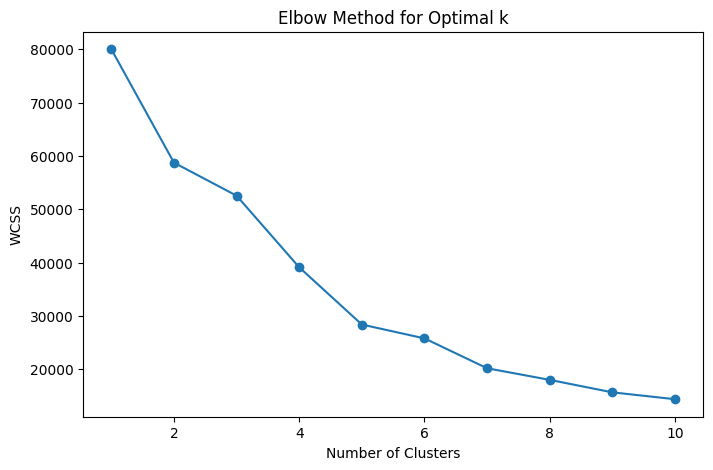

In [32]:
wcss = []  
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

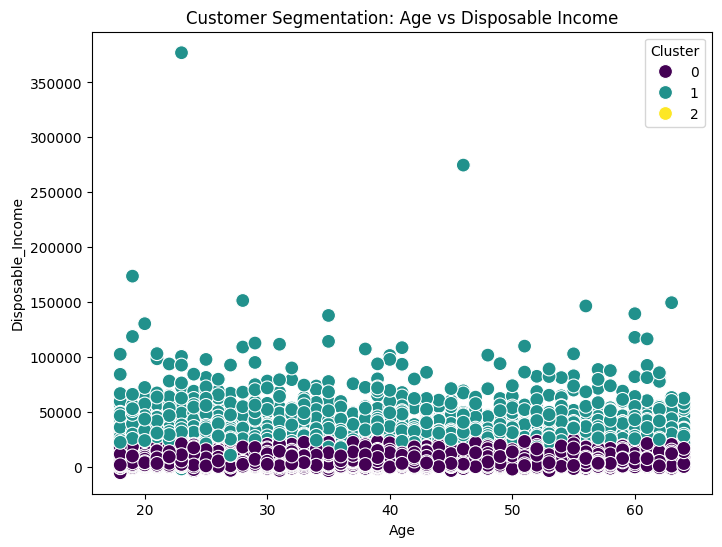

In [33]:
kmeans = KMeans(n_clusters=3, random_state=42)
merged['Cluster'] = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(8,6))
sns.scatterplot(data=merged, x='Age', y='Disposable_Income', hue='Cluster', palette="viridis", s=100)
plt.title("Customer Segmentation: Age vs Disposable Income")
plt.show()


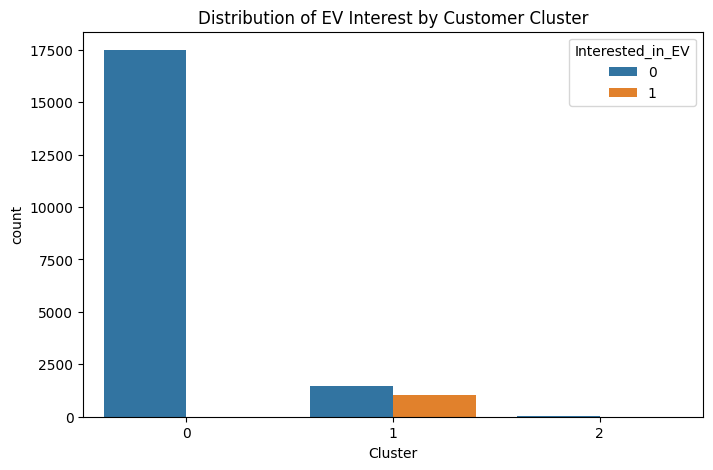

In [34]:
plt.figure(figsize=(8,5))
sns.countplot(data=merged, x='Cluster', hue='Interested_in_EV')
plt.title("Distribution of EV Interest by Customer Cluster")
plt.show()

In [35]:
cv_scores = cross_val_score(best_rf, X, y, cv=10, scoring='accuracy')
print("10-fold CV Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

10-fold CV Accuracy Scores: [1.     1.     1.     1.     0.9995 1.     1.     0.9995 1.     1.    ]
Mean CV Accuracy: 0.9999
